# Activity 6.1 Dimensionality Reduction

#### Objective:

This activity aims to perform reduction of dimensions using PCA

#### Intended Learning Outcomes (ILOs):
* Demonstrate how to use pipelining for transformation and scaling.
* Deomnstrate how to perform principal component analysis to reduce dimension.


#### Resources:
* Jupyter Notebook
* Wholesale customers data.csv
* Human_Activity_Recognition_Using_Smartphones_Data.csv

#### Procedure:

Import the data and check the data types.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

file = 'datasets/Wholesale customers data.csv'
data = pd.read_csv(file)
data.shape

(440, 8)

In [2]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

Drop the channel and region columns as they won't be used.

Copy this version of the data (using the `copy` method) to a variable to preserve it.

In [4]:
data = data.drop(['Channel', 'Region'], axis=1)

Convert the remaining columns to floats if necessary.

In [5]:
for col in data.columns:
    data[col] = data[col].astype(float)

Preserve the original data.

In [6]:
data_orig = data.copy()

Examine the correlation and skew.

In [7]:
corr_mat = data.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0

corr_mat

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,0.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.100510,0.000000,0.728335,0.123994,0.661816,0.406368
Grocery,-0.011854,0.728335,0.000000,-0.040193,0.924641,0.205497
Frozen,0.345881,0.123994,-0.040193,0.000000,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,0.000000,0.069291
Delicassen,0.244690,0.406368,0.205497,0.390947,0.069291,0.000000


In [8]:
corr_mat.abs().idxmax()

Fresh                         Frozen
Milk                         Grocery
Grocery             Detergents_Paper
Frozen                    Delicassen
Detergents_Paper             Grocery
Delicassen                      Milk
dtype: object

Interpret the result of the correlation

*Stripping the diagonal results in correlations that are equal to 1 to be zero. This makes sense since in this dataset, correlation between the same columns results to a correlation equal to exactly 1, which isn't what we want to see. We want to ignore those, so, they are set to zero instead.*

Examine the skew values and log transform.

In [9]:
log_columns = data.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Delicassen          11.151586
Frozen               5.907986
Milk                 4.053755
Detergents_Paper     3.631851
Grocery              3.587429
Fresh                2.561323
dtype: float64

In [10]:
for col in log_columns.index:
    data[col] = np.log1p(data[col])

Interpret the result

Type your answer here

Scale the data again

In [11]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in data.columns:
    data[col] = mms.fit_transform(data[[col]]).squeeze()

Using Scikit-learn's pipeline function, recreate the data pre-processing scheme above (transformation and scaling) using a pipeline

In [12]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# The custom NumPy log transformer
log_transformer = FunctionTransformer(np.log1p)

# The pipeline
estimators = [('log1p', log_transformer), ('minmaxscale', MinMaxScaler())]
pipeline = Pipeline(estimators)

# Convert the original data
data_pipe = pipeline.fit_transform(data_orig)

In [13]:
np.allclose(data_pipe, data)

True

Perform PCA with n_components ranging from 1 to 5. Store the amount of explained variance for each number of dimensions.Also store the feature importance for each number of dimensions.

In [14]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):

    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(data)

    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))

    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n,
                                             'features': data.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.448011
2,PCA(n_components=2),0.72099
3,PCA(n_components=3),0.827534
4,PCA(n_components=4),0.923045
5,PCA(n_components=5),0.979574


Create a table of feature importances for each data column.

In [15]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,Delicassen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
n,,,,,,
1,0.071668,0.335487,0.060620,0.095979,0.190236,0.246010
2,0.151237,0.177519,0.158168,0.222172,0.112032,0.178872
3,0.165518,0.145815,0.211434,0.268363,0.084903,0.123967
4,0.224259,0.149981,0.239527,0.214275,0.070971,0.100987
5,0.211840,0.182447,0.196382,0.178104,0.067338,0.163888


Create a plot of explained variances.

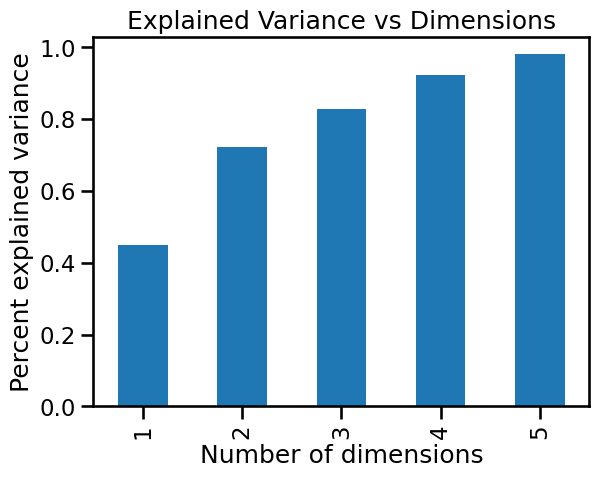

In [16]:
sns.set_context('talk')

ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

And here's a plot of feature importances.

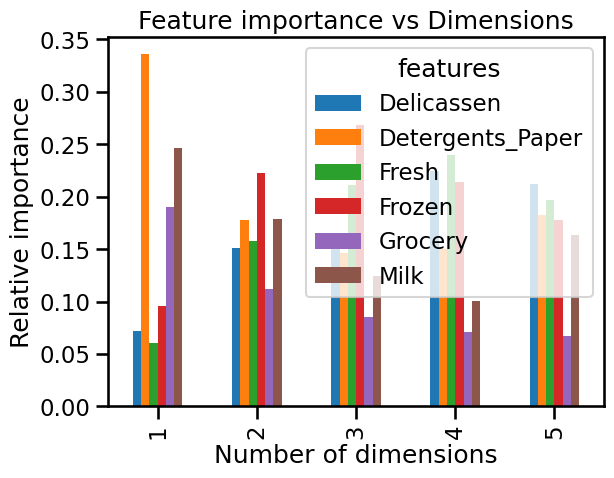

In [17]:
ax = features_df.plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

Let us include the PCA in building the model using logistic regression and pipeline.

Load the dataset.

In [20]:
filepath = 'datasets/Human_Activity_Recognition_Using_Smartphones_Data-1.csv'
df = pd.read_csv(filepath)

Create a pipeline, then predicts the "Activity" column over a 5-fold StratifiedShuffleSplit, and returns the average test accuracy

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = df.drop('Activity', axis=1)
y = df.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(max_iter = 5000))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

Plot the average accuracy by number of dimensions.

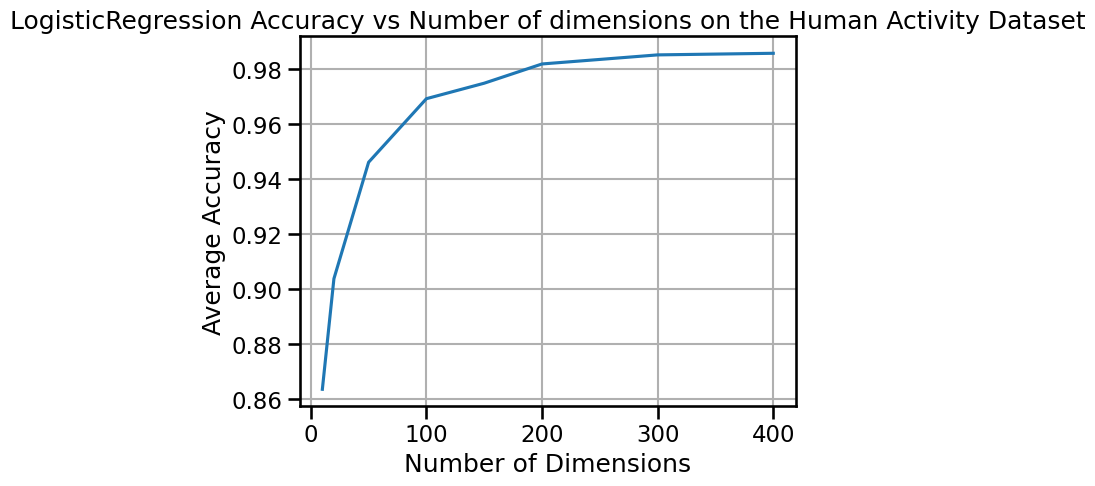

In [22]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)

#### Supplementary Activity:


* Choose your own dataset.


*The chosen dataset for this activity is the [NATICUSdroid](https://archive.ics.uci.edu/dataset/722/naticusdroid+android+permissions+dataset), which contains permissions extracted from more than 29000 benign and malware Android apps released from 2010-2019.*

*The instances in this dataset represent a presence of a permission in an Android application.*

* Import the dataset


In [ ]:
import pandas as pd
naticus = pd.read_csv('datasets/NATICUSdroid.csv')
naticus.head()

* Determine the number of datapoints, columns and data types


In [ ]:
print("Number of datapoints (rows):", naticus.shape[0])
print("Number of columns:", naticus.shape[1])
print("\nData types:\n", naticus.dtypes)

* Remove unneccesary columns


*I don't think there are unnecessary columns in this dataset, since each column represents an Android app.*

* Do data cleaning such as removing empty values(NaN), replacing missing data .


In [ ]:
#check for missing values
print("\nMissing values per column:\n", naticus.isnull().sum())

* Standardize the variables (if necessary).


*Since the values in the instances within the dataset are all boolean values, no standardization of variables is necessary*

* Perform descriptive statistics such as mean, median and mode


In [ ]:
naticus.mean()

* Perform data visualization


* Use pipelining.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = df.drop('Activity', axis=1)
y = df.Activity
sss = StratifiedShuffleSplit(n_splits=5, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression(max_iter = 5000))
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [10, 20, 50, 100, 150, 200, 300, 400]
score_list = [get_avg_score(n) for n in ns]

* Perform PCA


* Use logistic regression with PCA.


* Plot the average accuracy by number of dimensions.

#### Conclusion

Type your answer here